FaceNet is a deep neural network used for extracting features from an image of a person’s face. It was published in 2015 by Google researchers Schroff et al. 

FaceNet takes an image of a face as input and outputs the embedding vector.

How it works?

Text(0.5, 1.0, 'Facenet - How it works?')

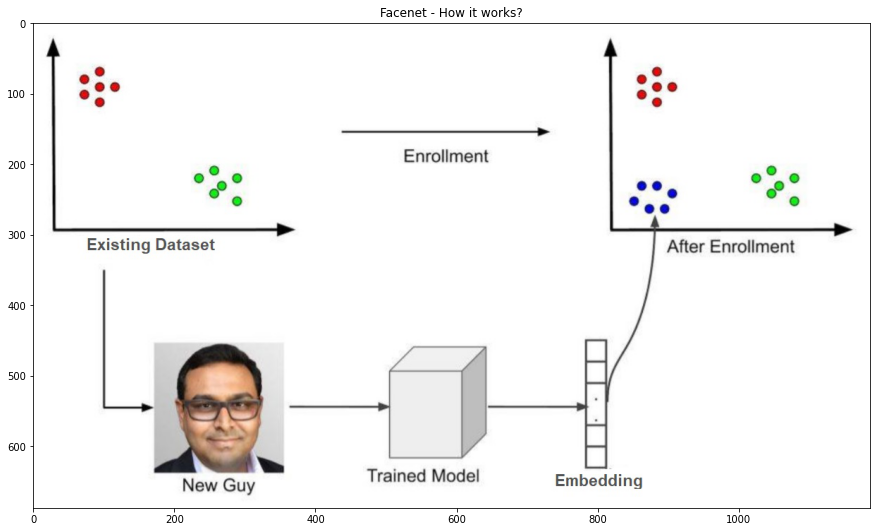

In [6]:
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg


img = mpimg.imread('/content/facenet-enrollment.jpg')
fig, ((ax1)) = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
ax1.imshow(img)
ax1.set_title("Facenet - How it works?")

In [4]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 8.3 MB/s 


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


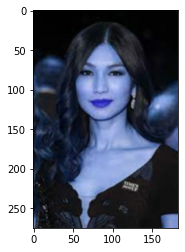

(275, 183, 3)


In [ ]:
img = cv2.imread('/content/gema.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

1/1 [==============================] - 0s 117ms/step


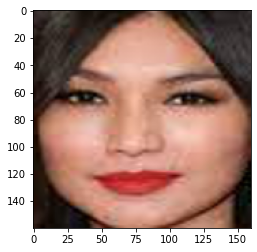

(160, 160, 3)


In [ ]:
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('/content/gema.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [ ]:
import os
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('/content/gdrive/MyDrive/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/gdrive/MyDrive/test/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

1/1 [==============================] - 0s 129ms/step
loaded 6 sample for class: avril
1/1 [==============================] - 0s 121ms/step
loaded 4 sample for class: drake
1/1 [==============================] - 0s 109ms/step
loaded 4 sample for class: madona
1/1 [==============================] - 0s 147ms/step
loaded 5 sample for class: rihana
1/1 [==============================] - 0s 106ms/step
loaded 4 sample for class: shakira
(23, 160, 160, 3) (23,)
1/1 [==============================] - 0s 117ms/step
loaded 1 sample for class: avril
1/1 [==============================] - 0s 123ms/step
loaded 1 sample for class: madona
1/1 [==============================] - 0s 112ms/step
loaded 2 sample for class: rihana
1/1 [==============================] - 0s 108ms/step
loaded 1 sample for class: shakira
loaded 0 sample for class: .ipynb_checkpoints
(5, 160, 160, 3) (5,)


In [ ]:
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (23, 160, 160, 3) (23,) (5, 160, 160, 3) (5,)


In [ ]:
# ! wget https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5

facenet_model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [ ]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 69ms/step
(23, 128)
1/1 [==============================] - 0s 68ms/step
(5, 128)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=23, test=5
Accuracy: train=100.000, test=100.000


Predicted: 
['avril' 'drake' 'madona' 'rihana' 'shakira'] 
[71.58691058  5.26117283  7.65186671  5.71334221  9.78670768]
Expected: avril


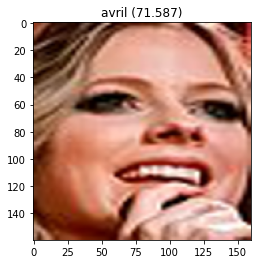

In [ ]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
